## MiniLab Project Requirments -
1. [Data Preparation](#DataPreparation)
    1. [Data preperation: Adjustments](#DataPrep)
    2. [Data preperation for Support Vector Machine](#SVGDataSet)

2. [Modeling and Evaluation](#ModelEvaluation)
    1. [Create a logistic regression model](#LRM)
    2. [Evaluation of logistic regression model](#LRMEval)
    3. [Support Vector Machine model](#SVG)
    4. [SVG evaluation](#SVGEval)
    5. [Discuss the advantages of each model for each classification task](#Advantages)
    6. [Use the weights from logistic regression to interpret the importance of features for each classification task](#Weights)
    7. [Look at the chosen support vectors for the classification task. Do these provide any insight into the data?](#SVGInsights) 
    8. [Additional Model: Gradient Boosted Decision Tree (GBDT)](#GBDT)
3. [Modeling Conclusions](#Conclusions)


# Mel Schwan, Stuart Miller, Justin Howard, Paul Adams
# Mini Lab: Logistic Regression and Support Vector Machine

In MiniLab2 we will perform predictive analysis (classification) upon a data set we cleaned in the Lab1. We will model the dataset using methods we have discussed in class. Logistic regression and support vector machines will be used in making conclusions from the analysis. The following phases of CRISP will be documented it the notebook.


<img src="./crisps-dm-minilab.png" style="width:550px;height:450px"/>


# 1. Stage Three - Data Preparation (Q1)   <a class="anchor" id="DataPreparation"></a>

To produce useful descriptive and predictive models, our team found it necessary to systematically re-examine assumptions we previously held. During our modeling process, we produced and evaluating models, used the evaluations to introducing changes to the dataset and apply treatments to the data, and progress toward more useful models.
The product of the Data Preparation and Modeling Phases produced valuable insights into our dataset:
1. We discovered unfounded bias against features we previously deemed less useful
2. We found it necessary to research and experiment with a variety of sampling techniques

## 1.1 Data preparation: Adjustments (Q1A)<a class="anchor" id="DataPrep"></a>

The dataset we are analyzing consists of a mixture of attributes scraped from loan applications and credit bureaus. Overall, the dataset is sparsely populated due to Home Credit's focus on applicants with little to no credit history. 

**Assumption Changes:**
1. The EXTERNAL_SOURCE_1 and OWN_CAR_AGE features contribute significantly to a predictive model and were re-introduced to the dataset.
2. The CNT_FAM_MEMBERS, CNT_CHILDREN, CREDIT_ACTIVE, LOAN_COUNT were more valuable as binned categorical features than as high-cardinality integer counts.
3. Using under-sampling techniques produced better results than over-sampling techniques did.



In [1]:
# Import Libraries Required.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy import stats

#removing warnings
import warnings
warnings.simplefilter('ignore')

In [2]:
# loading data that was preprocessed using the custom read_clean_data() function, 
# merged with the previously engineered newFeatures from Lab 1 

data = pd.read_csv('data.csv', na_values = 'XNA')

**Reducing High Cardinality Features**

In [3]:
data.CNT_FAM_MEMBERS.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  9.,  7.,  8., 10., 13., 14., 12.,
       20., 15., 16., 11.])

The dataset contains features, such as the number of children an applicant has, where the number of unique values are relatively high, but the percentage of the total makeup is almost imperceptable. The distributions of these high cardinality variables are heavily skewed. To address this issue, the number of numeric categories was reduced to get a more accurate interpretation of their impact on the target variable.

In [4]:
#recoding high cardinality features

# reducing the child count feature to 3 categories
def cnt_child(series):
    if series == 0 :
        return 'No Children'
    elif 1 <= series < 5 :
        return '1-4 Children'
    else :
        return '5 or More Children'
data['cnt_child'] = data.CNT_CHILDREN.apply(cnt_child).astype('category')

# reducing family count feature to 4 categories
def cnt_family(series):
    if series == 1:
        return '1 Family Member'
    elif series == 2: 
        return '2 Family Members'
    elif 3 >= series <= 5:
        return '3 - -5 Family Members'
    else :
        return '6 or more Family Members'
data['cnt_family'] = data.CNT_FAM_MEMBERS.apply(cnt_family).astype('category')

# reducing engineered feature CREDIT_ACTIVE to 4 categories
data.CREDIT_ACTIVE = data.CREDIT_ACTIVE.astype(np.uint32)

def credit_active(series):
    if series == 0:
        return 'No Accounts'
    elif 1 <= series <= 3:
        return '1-3 Accounts'
    else : 
        return ' > 4 Accounts'
data['credit_active'] = data.CREDIT_ACTIVE.apply(credit_active).astype('category')

# reducing engineered feature LOAN_COUNT to 5 categories

def loan_count(series):
    if series == 0:
        return 'No Loans'
    elif 1 <= series <= 2:
        return '1-2 Loans'
    elif 3 <= series <= 5:
        return '3-5 Loans'
    elif 6 <= series <= 10:
        return '6-10 Loans'
    else : 
        return ' > 10 Loans'

data['loan_cnt'] = data.LOAN_COUNT.apply(loan_count).astype('category')

In [18]:
data.shape

(307511, 93)

### 1.1.1 Second Principal Component Analysis

Our feature selection decisions prompted a review of the Principal Components to see if a more signficant separation between the classes is evident.

In [6]:
# dropping variables that were deemed the least useful for analysis
new_df = data.copy().drop(['TARGET', 'SK_ID_CURR', 'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                          'CNT_FAM_MEMBERS', 'EXT_SOURCE_1_AV','EXT_SOURCE_2_AV', 'EXT_SOURCE_3_AV', 'LOAN_COUNT',
                          'CREDIT_ACTIVE'], axis = 1)
# one-hot encoding
# adding drop_first = True eliminates the duplication of categorical features that are already binary indicators
new_df = pd.get_dummies(new_df, drop_first = True)
pd.options.display.max_columns = 400
new_df.describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMPLOYED,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,PERCENT_EMPLOYED_TO_AGE,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_Y,FLAG_EMP_PHONE_Y,FLAG_WORK_PHONE_Y,FLAG_CONT_MOBILE_Y,FLAG_PHONE_Y,FLAG_EMAIL_Y,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_None,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,REG_REGION_NOT_LIVE_REGION_Y,REG_REGION_NOT_WORK_REGION_Y,LIVE_REGION_NOT_WORK_REGION_Y,REG_CITY_NOT_LIVE_CITY_Y,REG_CITY_NOT_WORK_CITY_Y,LIVE_CITY_NOT_WORK_CITY_Y,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_None,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATIO

In [7]:
sc = StandardScaler()
sc.fit(new_df)
X_train_std = sc.transform(new_df) 
X_train_std.shape

(307511, 192)

Our new one-hot encoded dataset contains 192 features.

In [8]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nTop Ten Eigenvalues \n%s' % eigen_vals[0:9])


Top Ten Eigenvalues 
[8.05794118 3.69872431 3.3721773  3.07843106 2.74807844 2.5065928
 2.46474647 2.35817835 2.17330381]


In [9]:
# calculating the total var explained and cumulative variance
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse =True)]
cum_var_exp = np.cumsum(var_exp)
len(var_exp)
len(cum_var_exp)
print("Variance Explained length: " + str(len(var_exp)), "\nCumulative Variance Explained length : " + str(len(cum_var_exp)))

Variance Explained length: 192 
Cumulative Variance Explained length : 192


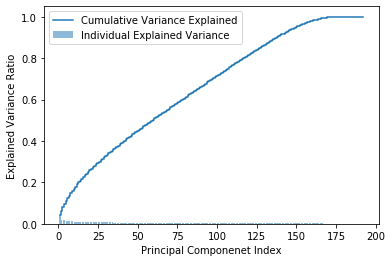

In [11]:
#plotting
import matplotlib.pyplot as plt

plt.bar(range(1,193), var_exp, alpha = .5, align = 'center', label = 'Individual Explained Variance')

plt.step(range(1,193), cum_var_exp, where = 'mid', label = 'Cumulative Variance Explained')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Componenet Index')
plt.legend(loc='best')
plt.show()

**Significant Findings**

To capture at least 80% of the variability in the dataset, we must include around 125 principal components. While this is a large number of features, our previous dataset contained 302 features. Our efforts to reduce the cardinality of several features were effective. 

We will pair the eigenvectors with their corresponding eigenvalues and project them onto a 2 dimensional subspace and observe the results.

In [12]:
# making a listof (eigenvalues, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

#sort the (eigenvalue, eigenvector) tuples from high to low
"""eigen_pairs[0] is equivalent to the single eigenvalue for PC1 and the eigenvector that represents the 190 features of the data"""
eigen_pairs.sort(key=lambda k: k[0], reverse = True)

#collecting the two eigenvectors that correspond to the two largest eigenvalues

W = np.hstack((eigen_pairs[0][1][:,np.newaxis],
               eigen_pairs[1][1][:,np.newaxis]))

# printing the first 5 pairs
print('Matrix W: \n', W[:5])

Matrix W: 
 [[-0.03506138 -0.11586833]
 [-0.03210574 -0.26698774]
 [-0.04883293 -0.24820111]
 [-0.00598899 -0.17655228]
 [ 0.2446064  -0.10475639]]


We can use this matrix to transform the training set into new features and plot them. First, we will observe the first 2 Principal Components with a logistic regression-based decision boundary to view the discriminatory ability of a logistic model using the Principal Components.

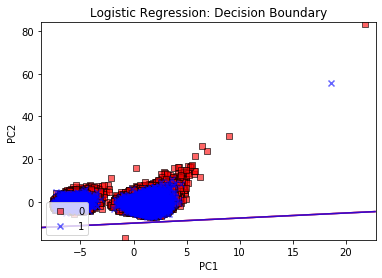

In [19]:
#helper script
from plot_decision_regions import plot_decision_regions
# other packages
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

#transforming training data
X_train_pca = X_train_std.dot(W)

# identifying labels
y_train = data.TARGET

#initializing the PCA transformer and logistic regression estimator:
pca = PCA(n_components =2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')
# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
#fitting the logitistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.title('Logistic Regression: Decision Boundary')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'lower left')
plt.show()

**Significant Findings**

From this plot, we can see that class separation is very poor and non-linear. We have two centroids where each has only a slight concentric-ellipse type of separation between the two classes. The decision boundary drawn by a logistic model is clearly unable to use the first two principal compoenents to discriminate between defaults and non-defaulted loans.

We can also attempt to view the value of the third principal component to see if there is good separation when a third dimension is added.

In [14]:
# getting three principal components
W3 = np.hstack((W,eigen_pairs[2][1][:,np.newaxis]))
W3.shape

(192, 3)

In [15]:
#transforming training data
X_train_pca3 = X_train_std.dot(W3)
X_train_pca3.shape

(307511, 3)

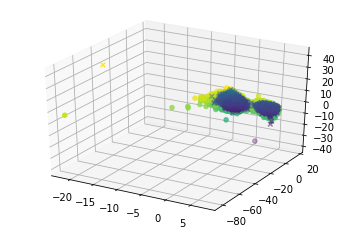

In [16]:
# 3-d plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


colors = ['r','g']
markers = ['o', 'x']

# for each index and class in:
for idx, cl in enumerate(np.unique(y_train)):
    ax.scatter3D(X_train_pca3[y_train == cl, 0],
                X_train_pca3[y_train == cl, 1],
                X_train_pca3[y_train == cl, 2],
                label = cl,  
                c = X_train_pca3[y_train == cl, 2],
                cmap = 'viridis',
                marker = markers[idx])

**Significant Findings**

A three dimensional plot of the data does provide some insights. Defaults can be separated along the third dimension, as indicated by the defaults being clustered in the blue region and the non-defaults being clustered in the green/yellow regions of the third Principal Component.

1. The overlap between the classes is so signficant even in the third dimension, that the boundary line is not clear.

2. We will apply sampling strategies that will clarify the class boundaries.

 ## 1.2 Data preperation for Support Vector Machine (Q1b) <a class="anchor" id="SVGDataSet"></a>


Fill

## 2.  Stage Four - Modeling and Evaluation (Q2) <a class="ModelEvaluation" id="EDA"></a>

## 2.1 Create a logistic regression model (Q2A) <a class="anchor" id="LRM"></a>


Fill

## 2.2 Evaluation of logistic regression model (Q2B) <a class="anchor" id="LRMEval"></a>

Fill

## 2.3  Support Vector Machine model (Q2C) <a class="anchor" id="SVG"></a>



Fill

## 2.4 SVG evaluation (Q2D) <a class="anchor" id="SVGEval"></a>


Fill

## 2.5 Discuss the advantages of each model for each classification task (Q2E) <a class="anchor" id="Advantages"></a>


Fill

## 2.6 Use the weights from logistic regression to interpret the importance of features for each classification task (Q2F) <a class="anchor" id="Weights"></a>


Fill

## 2.7 Look at the chosen support vectors for the classification task. Do these provide any insight into the data? (Q2G) <a class="anchor" id="SVGInsights"></a>


In [ ]:
Fill

## 2.8 Additional Models: Gradient Boosted Decision Tree (GBDT) <a class="anchor" id = 'GBDT'></a>

In addition to the required Logsitic Regression and Support Vector Classifiers, we trained a Gradient Boosted Decsion Tree using sklearn's experimental HistGradientBoostingCalssifier. The primary benefit of this modeling strategy is that histogram-based estimators can be orders of magnitude faster than regular Gradient Boosting Classifiers whe nthe number of samples is as large as our dataset. There is also little need for imputing values. 

We combined multiple stratification and sampling techniques to the data before training the model:
1. A stratefied training/test set by `TARGET` : to guarantee similar distributions
2. Random-undersampling by the engineered categorical `CAT_INCOME` : clarify the boundaries between income strata
3. Tomek Link under-sampling by `TARGET` : clarify the boundaries between `TARGET` classes

### 2.8.1 Stratified Sampling by Incomes

In [20]:
#create quantiles with simple category names based on the quantile ranges
CAT_INCOME = pd.qcut(data['AMT_INCOME_TOTAL'], q = 4,
                    labels = ['$25,659 - $112,500', '$112,500 - $147,150', '$147,150 - $202,500','$202,500 - $117,000,000'])

CAT_INCOME.values

[$147,150 - $202,500, $202,500 - $117,000,000, $25,659 - $112,500, $112,500 - $147,150, $112,500 - $147,150, ..., $147,150 - $202,500, $25,659 - $112,500, $147,150 - $202,500, $147,150 - $202,500, $147,150 - $202,500]
Length: 307511
Categories (4, object): [$25,659 - $112,500 < $112,500 - $147,150 < $147,150 - $202,500 < $202,500 - $117,000,000]

In [21]:
# simplifying category names
data['CAT_INCOME'] = CAT_INCOME.astype('category')
#use the get_dummies function to quickly find the percentage of the dataset that each quantile makes up
pd.get_dummies(data.CAT_INCOME).describe()

CAT_INCOME,"$25,659 - $112,500","$112,500 - $147,150","$147,150 - $202,500","$202,500 - $117,000,000"
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.327071,0.172943,0.267350,0.232636
std,0.469144,0.378199,0.442577,0.422513
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


We have divided the income feature into quantiles, we can collect a stratefied sample based on four categories of the income feature.

To stratefy based on these new categories, we must return to the original dataset, with `TARGET` included, to conduct a atratefied sampling based on income quantiles.

In [35]:
# forming new dataset with target included. We will still drop features that we already decided were not useful.
strat_inc = data.copy().drop(labels = ['SK_ID_CURR','AMT_GOODS_PRICE', 'CNT_CHILDREN',
                          'CNT_FAM_MEMBERS', 'EXT_SOURCE_1_AV','EXT_SOURCE_2_AV', 'EXT_SOURCE_3_AV', 'LOAN_COUNT',
                          'CREDIT_ACTIVE'], axis = 1)
#print(list(strat_inc.columns))

We see that `TARGET` and `CAT_INCOME` are present. We need both to stratify by income.

In [36]:
from sklearn.model_selection import train_test_split
# stratefy the training and test sets by the target first
# must keep TARGET in the training sets at this point to under sample by income
y = strat_inc.TARGET
X = strat_inc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1, stratify = y)
print('y_train count: ' + str(y_train.count()) + '\ny_test count: ' + str(y_test.count()) +
      '\nTotal: ' + str(y_train.count() + y_test.count()))

y_train count: 246008
y_test count: 61503
Total: 307511


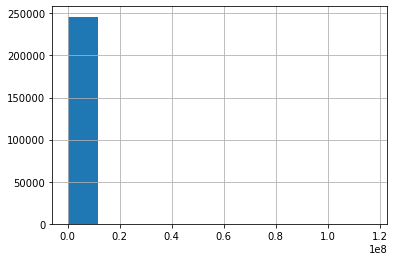

In [24]:
X_train.AMT_INCOME_TOTAL.hist()

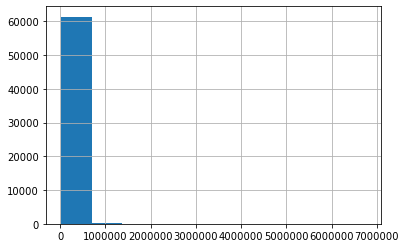

In [25]:
X_test.AMT_INCOME_TOTAL.hist()

Our training and test sets are taken from the same distribution.

We will now under sample according to income.

We will now take the training set and undersample all the categories expect the majority category.

In [37]:
from imblearn.under_sampling import RandomUnderSampler

# We are deciding to under sample all strata except the majority class
rus = RandomUnderSampler(random_state = 1, sampling_strategy = 'not majority')

# we are undersampling based on strata defined by the CAT_INCOME variable
y_inc = X_train.CAT_INCOME
X_rus, y_rus = rus.fit_resample(X_train,y_inc)
X_rus.shape

(208191, 85)

We will take the X_rus training data, which is randomly under sampled by income and undersample according to the TomekLinks to make the boundary between the classes more evident.

In [38]:
# preparing training data 
y_train = X_rus.pop('TARGET')
#getting dummy variables
X_train = pd.get_dummies(X_rus, drop_first = True)


# preparing test data for evaluation
y_test = X_test.pop('TARGET')
X_test = pd.get_dummies(X_test, drop_first = True)

# define a function to make empty features for missing features
cols = list(X_train.columns)
def add_missing_dummies(d, cols):
    missing_cols = set(cols) - set(d.columns)
    for c in missing_cols:
        d[c] = 0
add_missing_dummies(X_test, cols)

print('Shape of Training set: ' + str(X_train.shape) + '\nShape of Test set: ' + str(X_test.shape))

Shape of Training set: (208191, 195)
Shape of Test set: (61503, 195)


In [39]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_tl, y_tl = tl.fit_sample(X_train, y_train)

In [42]:
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
 # now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# comparing the training set that is under sampled by income AND undersampled by the tomeklinks along the boundary between classes
clf = HistGradientBoostingClassifier().fit(X_tl, y_tl)
cross_val_score(clf, X_tl, y_tl, cv = 5, scoring = 'recall')

array([0.30322772, 0.19923031, 0.00236827, 0.01983422, 0.02013025])

In [46]:
from sklearn.metrics import confusion_matrix
# using it on test set
y_pred = clf.predict(X_test)
results = confusion_matrix(y_test, y_pred)

accuracy = (results[0][0] + results[1][1])/(len(y_pred))
precision = results[0][0]/(results[0][0] + results[0][1])
recall = results[1][1]/ (results[1][1] + results[0][1])

print('Accuracy: ' + str(accuracy),
      '\nPrecision: ' + str(precision),
      '\nRecall: ' + str(recall))

Accuracy: 0.9194673430564363 
Precision: 0.9995224450811844 
Recall: 0.5909090909090909


Stratified undersampling by incomes combined with undersampling by target class using TomekLinks provides a much higher recall percentage without a loss of accuracy. 

## 3.0 Modeling Conclusions (Q3) <a class="anchor" id="Conclusions"></a>

Fill